In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd '/content/drive/My Drive/colab'

/content/drive/My Drive/colab


In [4]:
!pip install torch
!pip install tensorboardX

In [5]:
import torch
print(torch.cuda.is_available())

True


In [0]:
import pandas as pd
import numpy as np

import pickle
import os
import random
from collections import defaultdict

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
!! unzip data.zip

['Archive:  data.zip',
 '   creating: data/',
 '  inflating: data/nice_embed_tsne.csv  ',
 '  inflating: data/acid_properties.csv  ',
 '  inflating: data/family_classification_sequences.tab  ',
 '  inflating: data/family_classification_metadata.tab  ']

In [7]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [0]:
def codone_to_int(codone):
    char0 = ord(codone[0]) - ord('A')
    char1 = ord(codone[1]) - ord('A')
    char2 = ord(codone[2]) - ord('A')
    return char0 + char1*26 + char2*26**2
  
def int_to_codone(value):
    chars = []
    for i in range(3):
      chars.append(chr(value % 26 + ord('A')))
      value //= 26
    return ''.join(chars)
  
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq
    
    return [codone_to_int(cropped_seq[i:i+3]) for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []
    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [0]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [10]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [0]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros(batch_size, dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

def build_frequencies(all_codones, dictionary):
    flat_codones = flatten(all_codones)
    word_frequency = defaultdict(lambda: 0)
    for codone in flat_codones:
        word_frequency[dictionary[codone]] += 1
    return word_frequency

In [0]:
dictionary = make_dictionary(all_codones)

In [0]:
word_frequency = build_frequencies(all_codones, dictionary)

In [0]:
def build_sample_table(word_frequency):
    '''
    Building a list of word indexes assuming unigram (raised to the 
    3/4rd power) distribution of words.
    '''
    sample_table = []
    sample_table_size = 1e6
    pow_frequency = np.array(list(word_frequency.values()))**0.75
    words_pow = sum(pow_frequency)
    ratio = pow_frequency / words_pow
    count = np.round(ratio * sample_table_size)
    for wid, c in enumerate(count):
        sample_table += [wid] * int(c)
    return np.array(sample_table)

sample_table = build_sample_table(word_frequency)

In [0]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [0]:
class SkipGramModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.u_embeddings = nn.Embedding(vocab_size, embed_size) # Embeddings for central positions
        self.v_embeddings = nn.Embedding(vocab_size, embed_size) # Embeddings for target positions
        
        eps = 0.5 / self.embed_size
        self.u_embeddings.weight.data.uniform_(-eps, eps)
        self.v_embeddings.weight.data.uniform_(-0, 0)
                  
    def forward(self, pos_u, pos_v, neg_v):
        embeds_u = self.u_embeddings(pos_u)
        embeds_v = self.v_embeddings(pos_v)
        pos_score = torch.mul(embeds_u, embeds_v).squeeze().sum(dim=1)
        pos_score = F.logsigmoid(pos_score)
        
        neg_emb_v = self.v_embeddings(neg_v)
        neg_score = torch.bmm(neg_emb_v, embeds_u.unsqueeze(2)).squeeze()
        neg_score = F.logsigmoid(-1 * neg_score)
        return -1 * (torch.sum(pos_score) + torch.sum(neg_score))

In [0]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100      # Dimension of the word embedding vectors
NUM_SAMPLED = 5       # Number of negative examples to sample.
LEARNING_RATE = .025
NUM_TRAIN_STEPS = 1000000
SKIP_STEP = 25000

def train_embeddings(batch_gen):        
    torch.manual_seed(1)
    np.random.seed(1)
    
    cuda_available = torch.cuda.is_available()

    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE)
    if cuda_available:
        model = model.cuda()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
    for step in range(1, NUM_TRAIN_STEPS + 1):
        centers, targets = next(batch_gen)
        pos_u = centers
        pos_v = targets
        neg_v = numpy.random.choice(sample_table, size=(len(pos_word_pair), count)).tolist()
    
        pos_u = torch.tensor(pos_u, dtype=torch.long)
        pos_v = torch.tensor(pos_v, dtype=torch.long)
        neg_v = torch.tensor(neg_v, dtype=torch.long)
        if cuda_available:
            pos_u = pos_u.cuda()
            pos_v = pos_v.cuda()
            neg_v = neg_v.cuda()

        optimizer.zero_grad()
        loss = model.forward(pos_u, pos_v, neg_v)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if step % SKIP_STEP == 0:
            print('Average loss at step {}: {:5.1f}'.format(step, total_loss / SKIP_STEP))
            total_loss = 0.0
    
    if cuda_available:
        embedding = model.u_embeddings.weight.cpu().data.numpy()
    else:
        embedding = model.u_embeddings.weight.data.numpy()
    return embedding

In [18]:
final_embed_matrix = read_or_create(read_path='data/embeddings.pickle',
                                    producer=lambda: train_embeddings(batch_gen))

reading data/embeddings.pickle


In [19]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(map(lambda value: int_to_codone(value), list(unique_codones)))
tsne_df.head()

,x0,x1,codone
0,-3.066925,3.857965,AAA
1,6.082734,4.979094,CAA
2,-4.829814,10.487162,DAA
3,1.864359,6.428137,EAA
4,-1.224556,2.387624,FAA


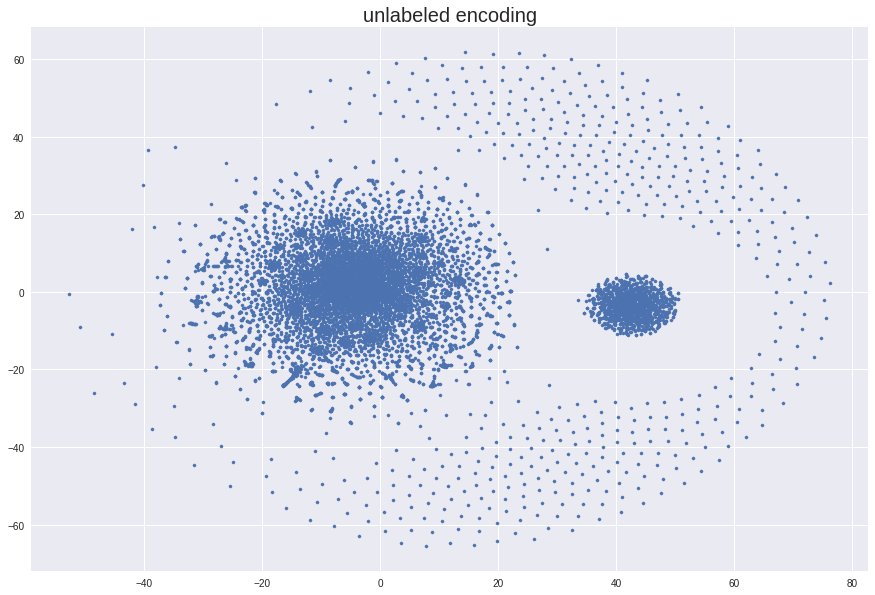

In [20]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()
    
plot_tsne_df(tsne_df)

In [0]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [0]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [23]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

saving data/all_acid_dicts.pickle


In [24]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,AAA,1.800000,71.077900,13.000000,88.600000
1,CAA,2.033333,81.766233,13.333333,95.233333
2,DAA,0.033333,85.747733,14.000000,96.100000
3,EAA,0.033333,90.423267,15.000000,105.200000
4,FAA,2.133333,96.443233,16.333333,122.366667


In [25]:
tsne_df.head()

,x0,x1,codone
0,-3.066925,3.857965,AAA
1,6.082734,4.979094,CAA
2,-4.829814,10.487162,DAA
3,1.864359,6.428137,EAA
4,-1.224556,2.387624,FAA


In [26]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,AAA,1.800000,71.077900,13.000000,88.600000,-3.066925,3.857965
1,CAA,2.033333,81.766233,13.333333,95.233333,6.082734,4.979094
2,DAA,0.033333,85.747733,14.000000,96.100000,-4.829814,10.487162
3,EAA,0.033333,90.423267,15.000000,105.200000,1.864359,6.428137
4,FAA,2.133333,96.443233,16.333333,122.366667,-1.224556,2.387624


In [0]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

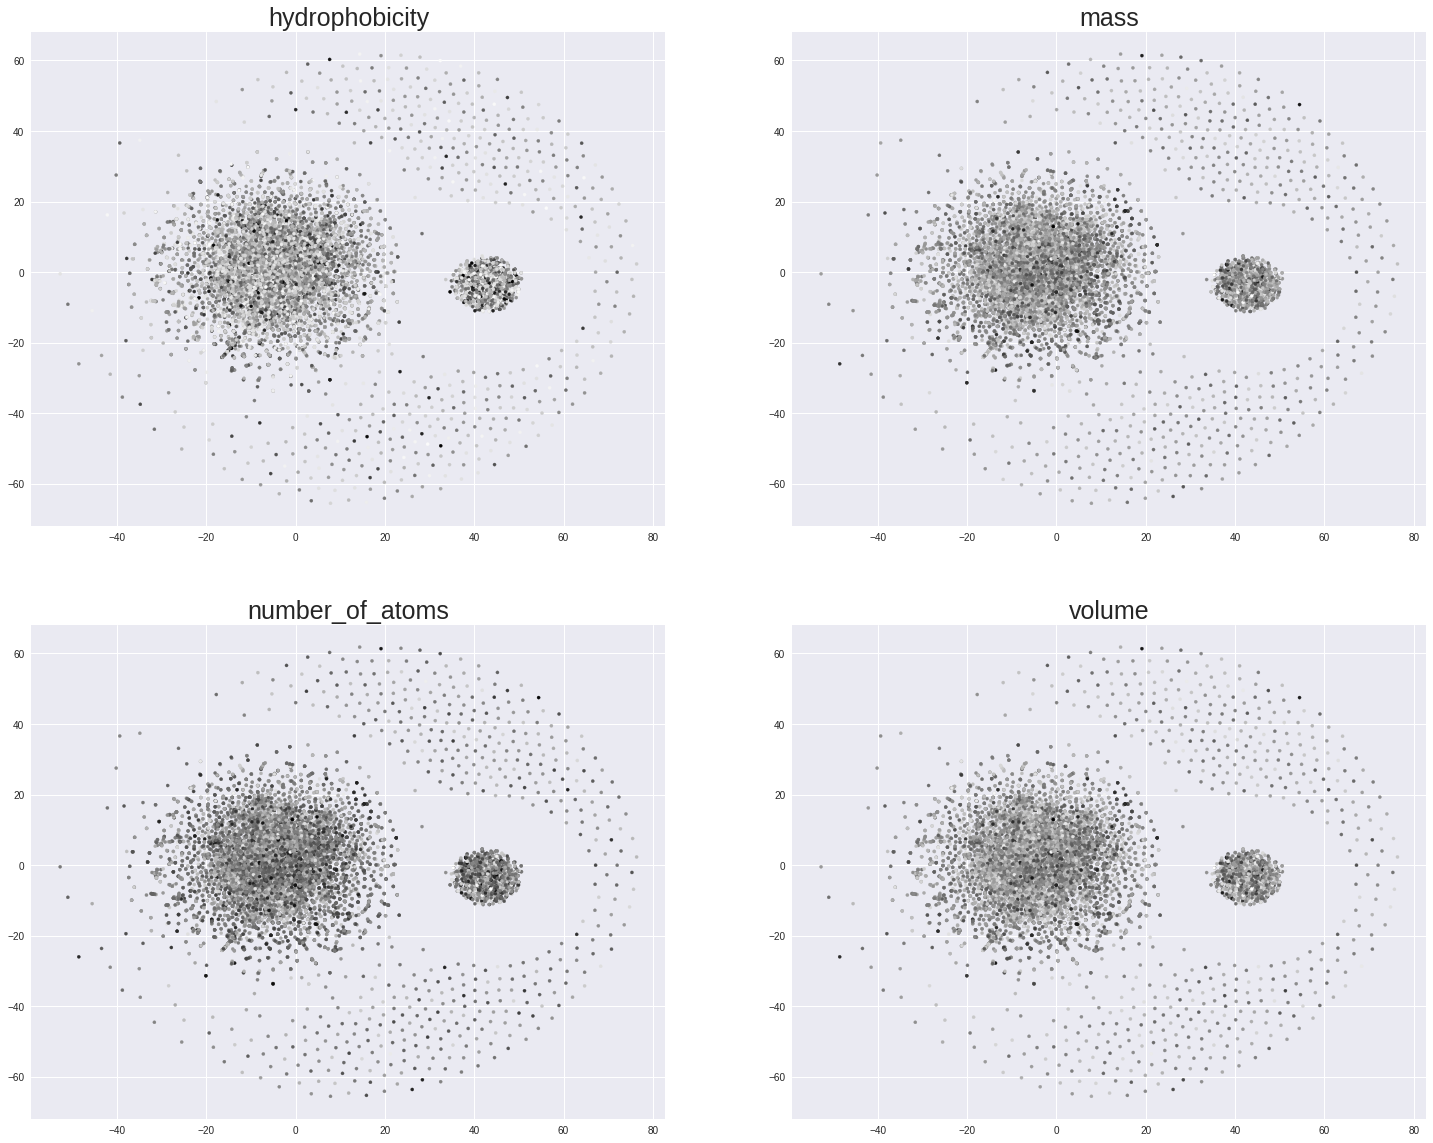

In [28]:
plot_embedding_properties(final_df)

In [0]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

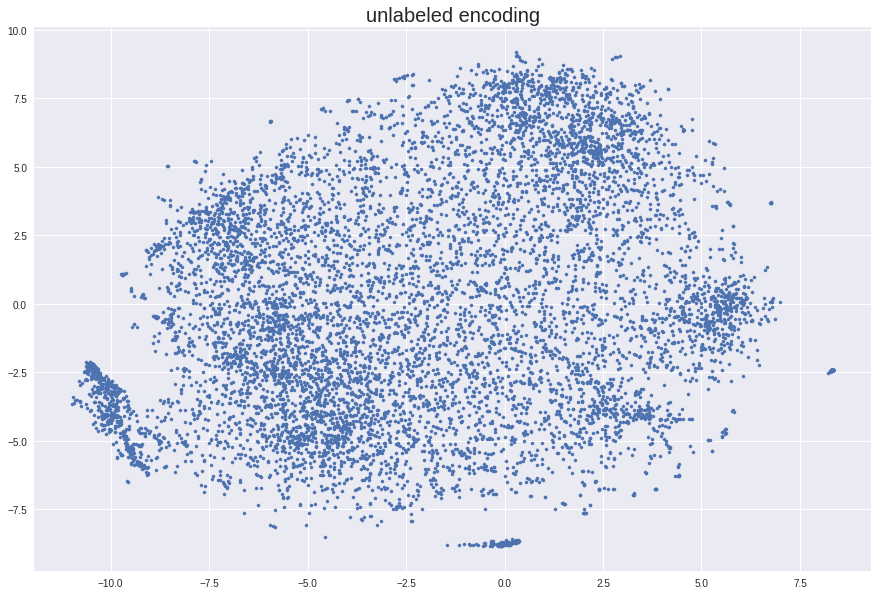

In [30]:
plot_tsne_df(gensim_tsne_df)

In [0]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

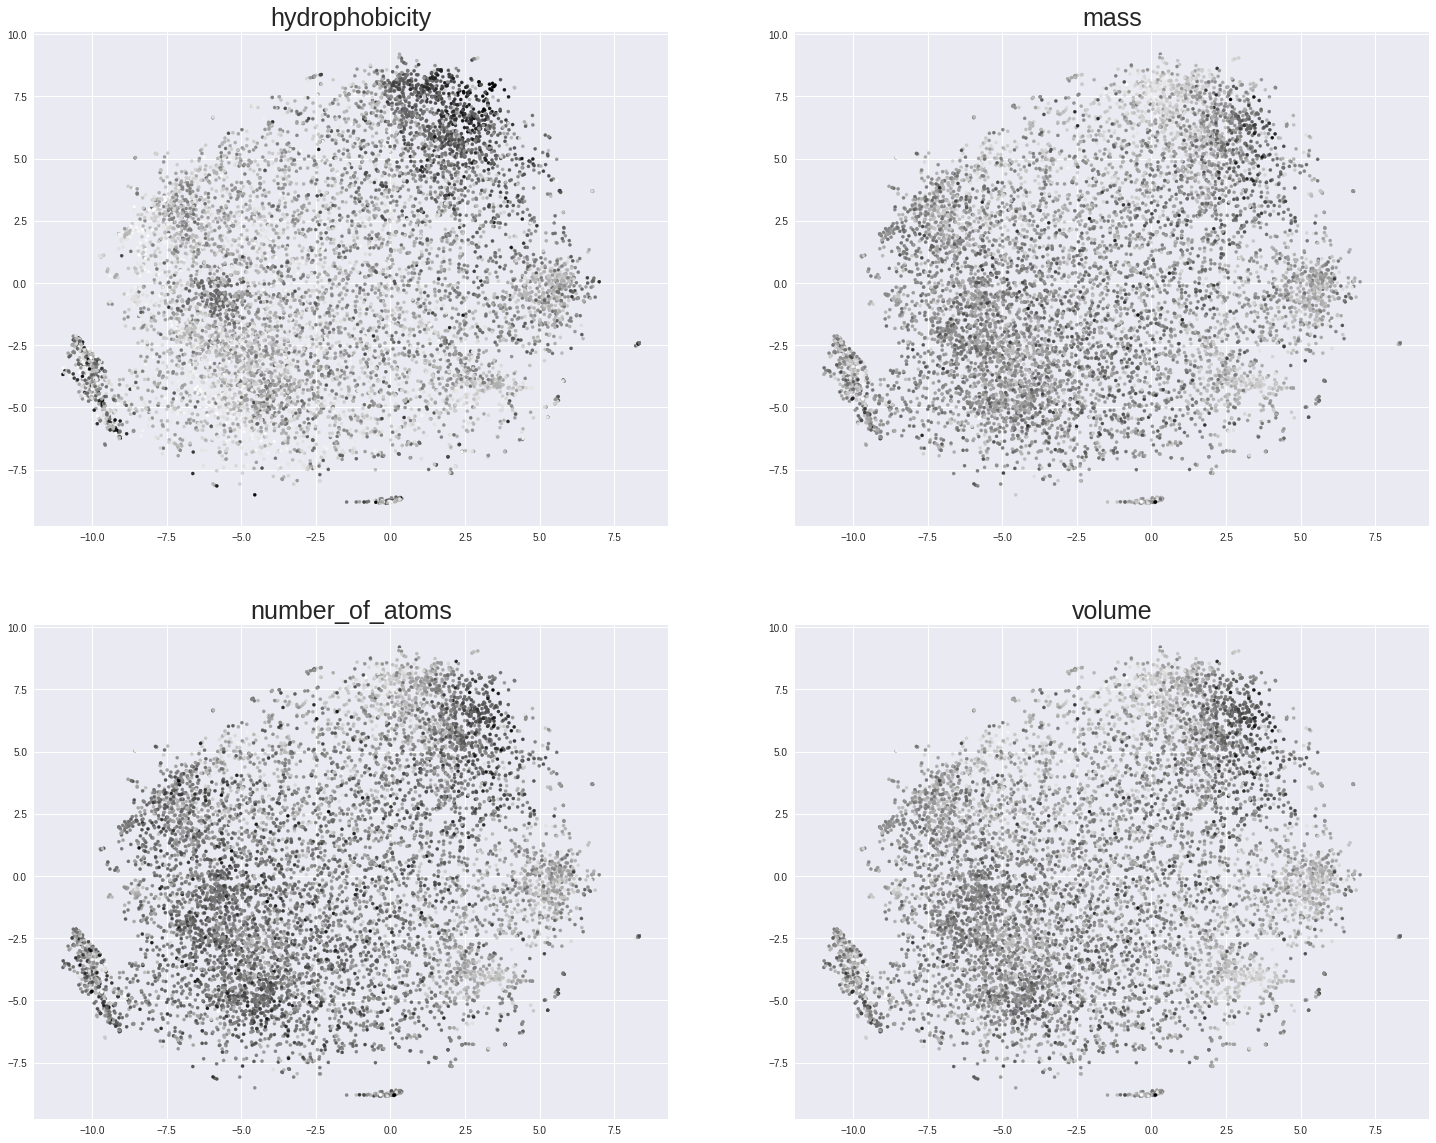

In [32]:
plot_embedding_properties(final_df_nice)

In [0]:
from tensorboardX import SummaryWriter

writer = SummaryWriter(log_dir='visual/')
writer.add_embedding(final_embed_matrix, tag="embeddings")
writer.close()

Then run tensorboard:

```
tensorboard --logdir *visual*/
```
And navigate to Projector -> T-SNE -> 3D and enjoy watching!